<h1>
    Q.1 Modeling 
</h1>

<h3>Skill:</h3>
<ul>
    <li>Player 1 skill: $s_1$</li>
    <li>Player 2 skill: $s_2$</li>
</ul>
Where: $s_1 \sim \mathcal{N}(\mu_1,\,\sigma^{2}_1)$

Where: $s_2 \sim \mathcal{N}(\mu_2,\,\sigma^{2}_2)$

<h3>Game outcome:</h3>
<ul>
    <li>$t = s_1 - s_2$</li>
</ul>
Where: $t \sim \mathcal{N}(\mu_t = s_1 - s_2,\,\sigma^{2}_t)$

<h3>Game result:</h3>
<ul>
    <li>If player 1 wins: $y = 1$</li>
    <li>If player 2 wins: $y = -1$</li>
</ul>

<h3>Bayesian model:</h3>
<ul>
    <li>$P(s_1, s_2, t, y) = P(y|t) \cdot P(t|s_1, s_2) \cdot P(s_1) \cdot P(s_2)$</li>
</ul>
Where: 
<ul>
    <li>$P(y|t)$ Game result given game outcome</li>
    <li>$P(t|s_1, s_2)$ Game outcome given player skills</li>
    <li>$P(s_1)$ and $P(s_2)$ Player skill priors</li>
</ul>

<h3>Hyperparameters:</h3>
<ul>
    <li>Player 1: $\mu_1$ and $\sigma^{2}_1$</li>
    <li>Player 2: $\mu_2$ and $\sigma^{2}_2$</li>
    <li>Unpredictability of the game outcome: $\sigma^{2}_t$</li>
</ul>

<h1>
    Q.2 Bayesian Network
</h1>

$s_1$ and $s_2$ influences $t$ 

$t$ then influences $y$

<h1>
    Q.3 Computing with the model
</h1>

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm

<h3>Initialization</h3>

<h3>$p(s1, s2|t, y)$ - Full conditional distribution of the skills</h3>

In [2]:
# Gaussian-Gaussian Bayesian Update
def update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples):
    A = np.array([[1, -1]])
    mu_prior = np.array([[s1_mean], [s2_mean]])
    sigma_prior = np.array([[s1_var, 0], [0, s2_var]])
        
    sigma_posterior = np.linalg.inv(np.linalg.inv(sigma_prior) + (t_var)**(-1) * (A.T @ A))
    mu_posterior = sigma_posterior @ (np.linalg.inv(sigma_prior) @ mu_prior + t_var**(-1) * A.T * t_samples)

    return mu_posterior, sigma_posterior

mean_s1 = 1
var_s1 =  1
mean_s2 = -1
var_s2 = 4
var_t = 5
t_obs = 3

mu_posterior, Sigma_posterior = update_skills(mean_s1,var_s1,mean_s2,var_s2,var_t,t_obs)
print("Posterior mean of s1 and s2:", mu_posterior)
print("Posterior covariance of s1 and s2:", Sigma_posterior)

Posterior mean of s1 and s2: [[ 1.1]
 [-1.4]]
Posterior covariance of s1 and s2: [[0.9 0.4]
 [0.4 2.4]]


# <h3>$p(t|s1, s2, y)$ - Full conditional distribution of the outcome</h3>

In [3]:
def conditional_distribution_t(s1, s2, y):
    t_mean = s1 - s2
    a, b = 0, 0
    
    if y == 1:
        a = 0
        b = np.inf
    else:
        a = -np.inf
        b = 0
    return t_mean, a, b

s1 = 2
s2 = 1
t_var = 5
y = 1

mu, a, b = conditional_distribution_t(s1, s2, y)

print(f"Parameters for p(t|s1, s2, y):\nmu_t: {mu}, sigma^2: {round(t_var,4)} \nBounds: [{a}, {b}]")

Parameters for p(t|s1, s2, y):
mu_t: 1, sigma^2: 5 
Bounds: [0, inf]


<h3>$p(y=1)$ - Marginal probability that Player 1 wins the game</h3>

In [4]:
# Marginal Probability that Player 1 Wins
def compute_marginal_probability(mu_t, var_s1, var_s2, var_t):
    sigma_t = np.sqrt(var_s1 + var_s2 + var_t)
    probability_y1 = 1 - norm.cdf(0, mu_t, sigma_t)
    
    return probability_y1

var_s1 =  1
var_s2 =  4
mu_t = 2
t_var = 5

prob_y1 = compute_marginal_probability(mu_t, var_s1, var_s2, t_var)
print(f"Marginal probability that Player 1 wins (p(y=1)): {round(prob_y1,4)}")
print(f"Marginal probability that Player 2 wins (p(y=-1)): {round(1-prob_y1,4)}")


Marginal probability that Player 1 wins (p(y=1)): 0.7365
Marginal probability that Player 2 wins (p(y=-1)): 0.2635


<h1>
    Q.4  A first Gibbs sampler
</h1>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time

def gibbs_sampling_trueskill(N, N_burn_in, match_properties):
    s1_mean = match_properties["s1_mean"]
    s1_var = match_properties["s1_var"]
    s1_std = np.sqrt(s1_var)
    
    s2_mean = match_properties["s2_mean"]
    s2_var = match_properties["s2_var"]
    s2_std = np.sqrt(s2_var)


    t_var = match_properties["t_var"]
    
    y = match_properties["y"]

    
    s1_samples, s2_samples, t_samples = np.zeros(N), np.zeros(N), np.zeros(N)
    s1_samples[0] = (np.random.normal(s1_mean, s1_std))
    s2_samples[0] = (np.random.normal(s2_mean, s2_std))
    
    for i in range(N - 1):
        t_mean = s1_samples[i] - s2_samples[i]
        t_mean, a, b = conditional_distribution_t(s1_samples[i], s2_samples[i], y)
        t_samples[i+1] = truncnorm.rvs(a = a, b = b, loc=t_mean, scale=np.sqrt(t_var))
    
        mu_posterior, sigma_posterior = update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples[i]) 
    
        s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T
    
    return np.array(s1_samples[N_burn_in:]), np.array(s2_samples[N_burn_in:]), np.array(t_samples[N_burn_in:])
    
start_time = time.time()
s1_mean = 25
s1_var = (25/3)
s2_mean = 25
s2_var = (25/3)
t_var = (25/6)
y = 1

match_properties = {
    "s1_mean": s1_mean,
    "s1_var": s1_var,
    "s2_mean": s2_mean,
    "s2_var": s2_var,
    "t_var": t_var,
    "y": y
}


N = 1000
N_burn_in = int(np.sqrt(N))

s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

C:\Users\claud\AppData\Local\Temp\ipykernel_3612\3160039245.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


Elapsed time:  0.3906095027923584


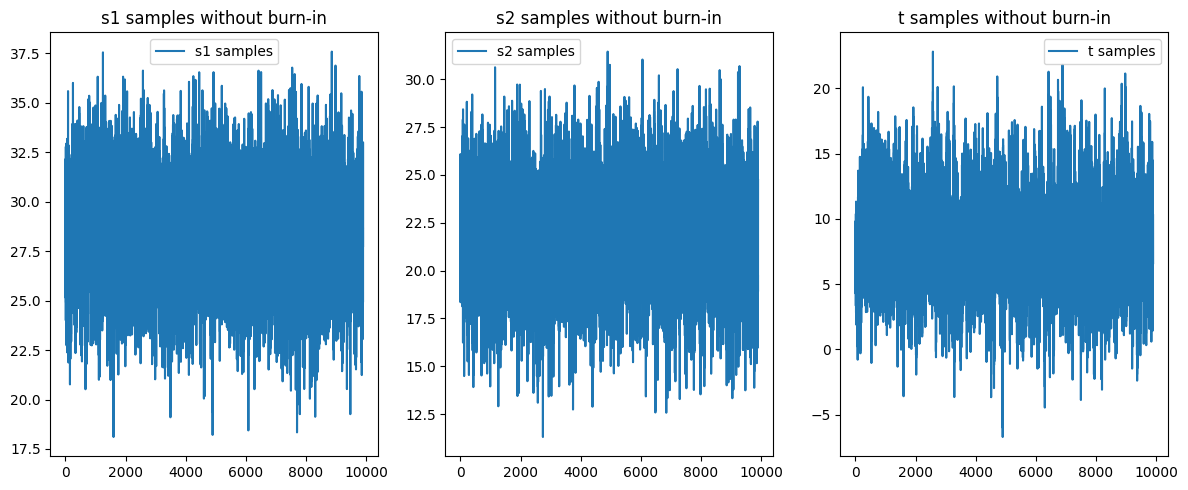

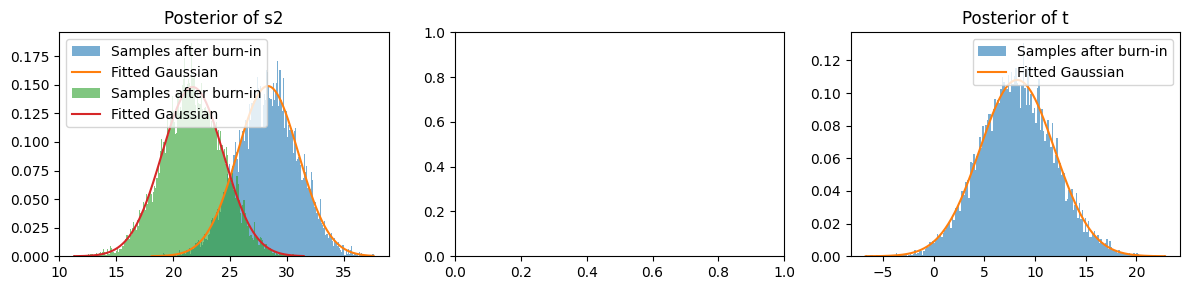

In [15]:
def plot_samples(s1_samples, s2_samples, t_samples):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].plot(s1_samples, label="s1 samples")
    ax[0].set_title("s1 samples without burn-in")
    ax[0].legend()
    
    ax[1].plot(s2_samples, label="s2 samples")
    ax[1].set_title("s2 samples without burn-in")
    ax[1].legend()

    ax[2].plot(t_samples, label="t samples")
    ax[2].set_title("t samples without burn-in")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

def plot_histogram_with_fitted_gaussian(samples, title, ax):
    mu = np.mean(samples)
    sigma = np.std(samples)
    ax.hist(samples, bins=2*int(np.sqrt(len(samples))), density=True, alpha=0.6, label="Samples after burn-in")
    ax.plot(np.linspace(min(samples), max(samples), 400), 
            norm.pdf(np.linspace(min(samples), max(samples), 400), mu, sigma), 
             label="Fitted Gaussian")
    ax.legend()
    ax.set_title(title)

plot_samples(s1_samples, s2_samples, t_samples)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_histogram_with_fitted_gaussian(s1_samples, "Posterior of s1", ax[0])
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s2", ax[0])
plot_histogram_with_fitted_gaussian(t_samples, "Posterior of t", ax[2])
plt.tight_layout()
plt.show()

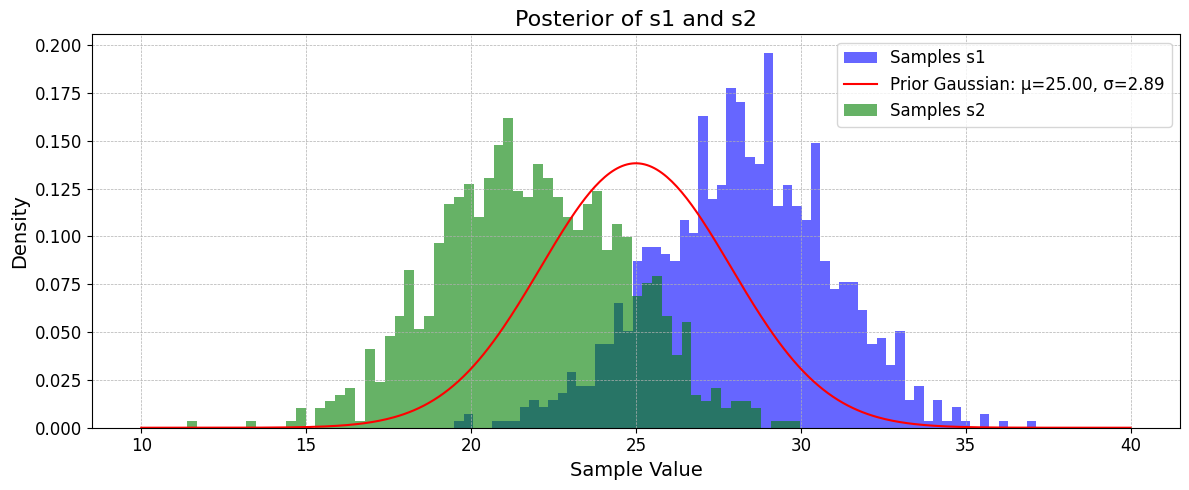

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_histogram_with_fitted_gaussian(samples, title, ax, i, color="blue"):
    # Calculate mean and standard deviation
    mu = (25)
    sigma = ((25/3)**0.5)
    
    # Plot histogram with a better binning strategy and specified color
    n_bins = 2*int(np.sqrt(len(samples)))
    ax.hist(samples, bins=n_bins, density=True, alpha=0.6, color=color, label=f"Samples s{i}")
    
    # Plot the fitted Gaussian
    if i == 1:
        x_vals = np.linspace(10, 40, 400)
        ax.plot(x_vals, norm.pdf(x_vals, mu, sigma), color="red", label=f"Prior Gaussian: μ={mu:.2f}, σ={sigma:.2f}")
    
    # Enhance the visual appeal
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Sample Value", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_histogram_with_fitted_gaussian(s1_samples, "", ax, 1, color="blue")
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s1 and s2", ax, 2, color="green")
plt.tight_layout()
plt.savefig("post_n_samples.png")
plt.show()

TypeError: plot_histogram_with_fitted_gaussian() missing 1 required positional argument: 'i'

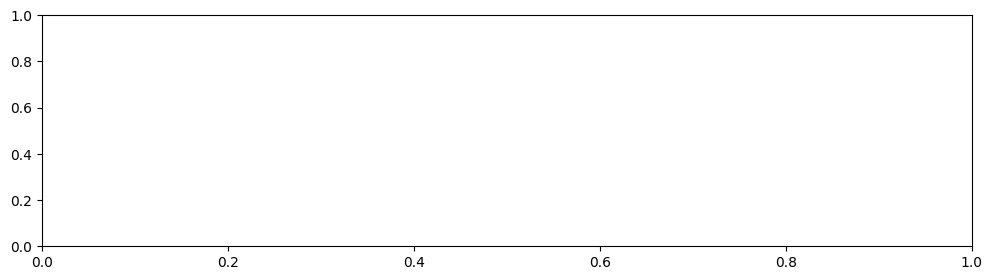

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_histogram_with_fitted_gaussian(s1_samples, "1", ax)
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s1 and s2, N = 10000", ax)

plt.savefig("post_n_10000.png")

In [48]:
mu1 = np.mean(s1_samples)
mu1

28.28914185026648

In [49]:
sigma1 = np.std(s1_samples)
sigma1

2.6618369235655415

In [50]:
mu2 = np.mean(s2_samples)
mu2

21.729760411471805

In [51]:
sigma2 = np.std(s2_samples)
sigma2

2.659738203146174

In [52]:
mu3 = np.mean(t_samples)
mu3

8.178375371890082

In [53]:
sigma3 = np.var(t_samples[2000:])
sigma3

13.02534092755762

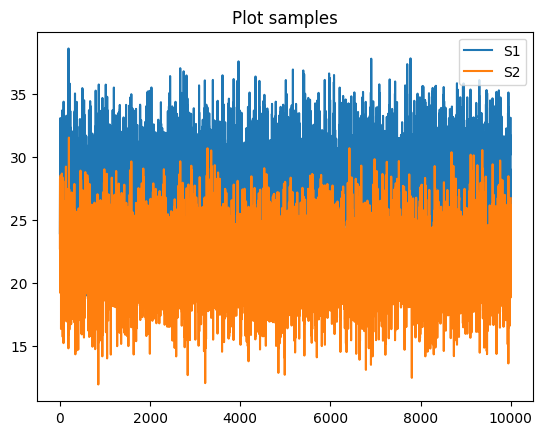

In [54]:
plt.plot(s1_samples, label="S1")
plt.plot(s2_samples, label="S2")
plt.title("Plot samples")
plt.legend()
plt.show()

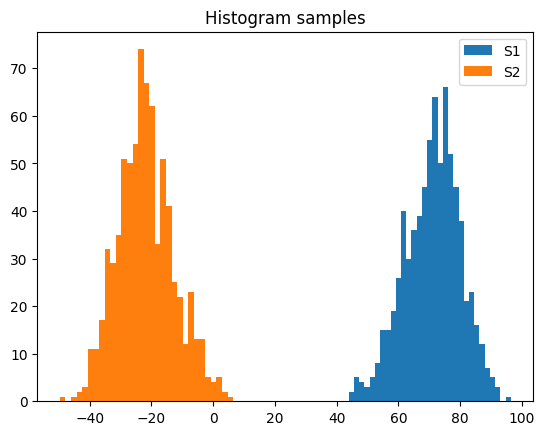

In [15]:
plt.hist(s1_samples, bins = int(N**0.5), label="S1")
plt.hist(s2_samples, bins = int(N**0.5), label="S2")
plt.title("Histogram samples")
plt.legend()
plt.show()

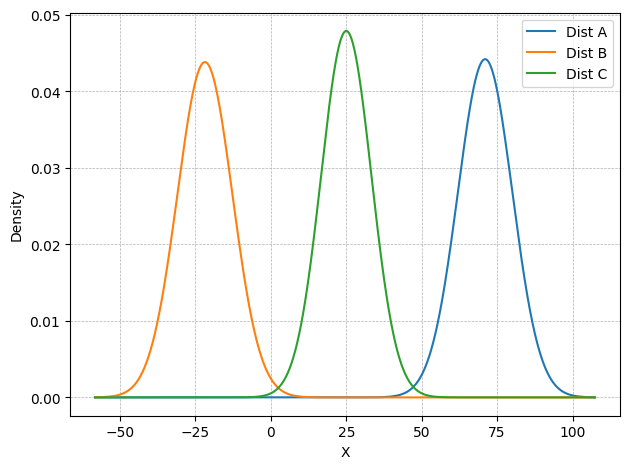

In [16]:
from scipy.stats import norm

def plot_normal_distributions(means, stds, labels=None, title="", xlabel="X", ylabel="Density"):
    """
    Plot multiple normal distributions overlaying each other.

    Parameters:
    - means: List of means for the normal distributions.
    - stds: List of standard deviations for the normal distributions.
    - labels: List of labels for the distributions.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    """
    
    # Create a range of x values to evaluate the distributions
    x = np.linspace(min(means) - 4 * max(stds), max(means) + 4 * max(stds), 1000)
    
    # If labels are not provided, create default labels
    if not labels:
        labels = [f"Dist {i}" for i in range(len(means))]
    
    # Plot each distribution
    for mean, std, label in zip(means, stds, labels):
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, label=label)
    
    # Set the title, labels, and display the legend
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Sample distributions
sample_means = [mu1, mu2, 25]
sample_stds = [sigma1, sigma2, (25/3)]
sample_labels = ["Dist A", "Dist B", "Dist C"]

# Plot the sample distributions
plot_normal_distributions(sample_means, sample_stds, sample_labels)


<h1>
    Q.5  Assumed Density Filtering
</h1>

In [61]:
import pandas as pd

seriea_df = pd.read_csv('SerieA.csv')

# Extract all unique teams
teams = list(set(seriea_df['team1'].unique()) | set(seriea_df['team2'].unique()))

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = (25/3)

team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}
team_skills


{'Sampdoria': {'mean': 25, 'variance': 8.333333333333334},
 'Bologna': {'mean': 25, 'variance': 8.333333333333334},
 'Parma': {'mean': 25, 'variance': 8.333333333333334},
 'Cagliari': {'mean': 25, 'variance': 8.333333333333334},
 'Juventus': {'mean': 25, 'variance': 8.333333333333334},
 'Genoa': {'mean': 25, 'variance': 8.333333333333334},
 'Milan': {'mean': 25, 'variance': 8.333333333333334},
 'Inter': {'mean': 25, 'variance': 8.333333333333334},
 'Atalanta': {'mean': 25, 'variance': 8.333333333333334},
 'Udinese': {'mean': 25, 'variance': 8.333333333333334},
 'Napoli': {'mean': 25, 'variance': 8.333333333333334},
 'Empoli': {'mean': 25, 'variance': 8.333333333333334},
 'Fiorentina': {'mean': 25, 'variance': 8.333333333333334},
 'Sassuolo': {'mean': 25, 'variance': 8.333333333333334},
 'Chievo': {'mean': 25, 'variance': 8.333333333333334},
 'Torino': {'mean': 25, 'variance': 8.333333333333334},
 'Frosinone': {'mean': 25, 'variance': 8.333333333333334},
 'Spal': {'mean': 25, 'variance'

In [21]:
N = 1000
N_burn_in = 250

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']
    
    # Skip the match if it's a draw
    if score1 == score2:
        continue
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 1
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

C:\Users\claud\AppData\Local\Temp\ipykernel_8968\3849995090.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


[('Juventus', 46.293675473156114),
 ('Napoli', 36.436050560511696),
 ('Inter', 28.929060965728485),
 ('Milan', 27.630679867548533),
 ('Roma', 25.074891166980642),
 ('Fiorentina', 24.440301703757704),
 ('Torino', 24.048864107073907),
 ('Sassuolo', 23.8398920528801),
 ('Lazio', 21.974922836845113),
 ('Sampdoria', 21.48245046120131),
 ('Atalanta', 19.816655421123436),
 ('Genoa', 19.263288385877626),
 ('Spal', 17.23212614923501),
 ('Parma', 15.41797021937899),
 ('Udinese', 14.483349353507222),
 ('Cagliari', 12.654778809907295),
 ('Empoli', 9.39484163106824),
 ('Bologna', 7.508348009636994),
 ('Frosinone', -0.18041564947141486),
 ('Chievo', -4.906289264095557)]

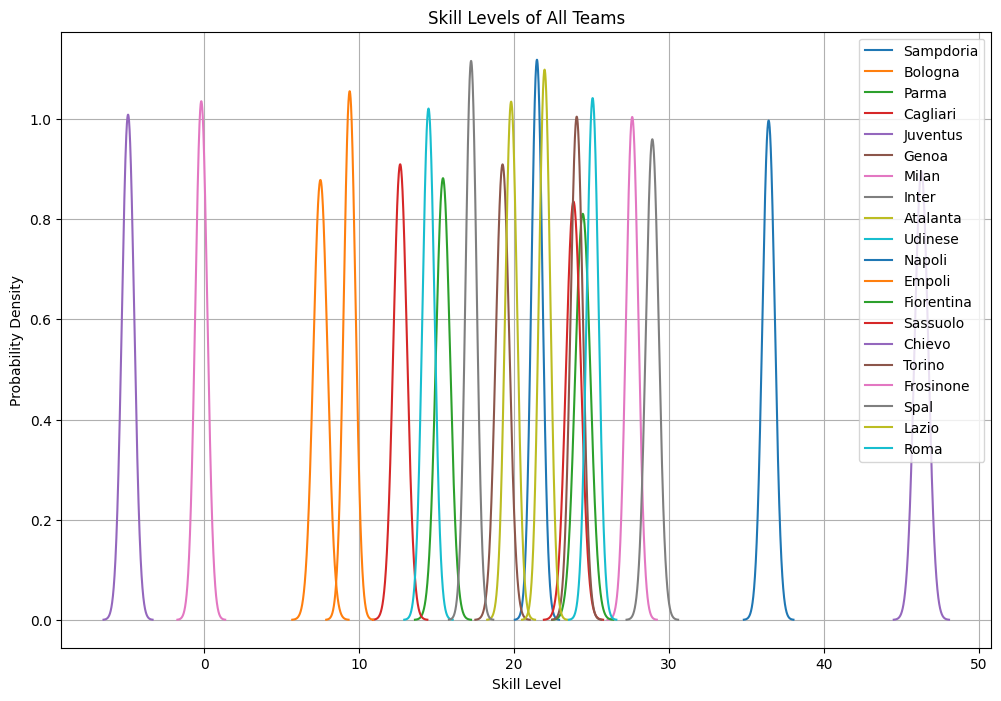

In [37]:
plt.figure(figsize=(12, 8))

for team in team_skills.keys():
    mean = team_skills[team]['mean']
    std_dev = np.sqrt(team_skills[team]['variance'])
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label=team)

plt.title('Skill Levels of All Teams')
plt.xlabel('Skill Level')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

<h1>
    Q.6 Using the model for predictions
</h1>

In [62]:
N = 1000
N_burn_in = 100

match_predictions = []

# Prediction function
def predict_winner(s1_mean, s1_var, s2_mean, s2_var):
    diff_mean = s1_mean - s2_mean
    diff_var = s1_var + s2_var
    # Compute the probability that Player 1's skill is greater than Player 2's skill
    return 1 if compute_marginal_probability(diff_mean, s1_var, s2_var, diff_var) > 0.5 else -1

correct_predictions = 0
total_predictions = 0

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']

    # Skip the match if it's a draw
    if score1 == score2:
        continue

    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Predict the winner based on current skill estimates
    prediction = predict_winner(
        team_skills[team1]['mean'], team_skills[team1]['variance'],
        team_skills[team2]['mean'], team_skills[team2]['variance']
    )

    # Append match details and prediction to the list
    match_predictions.append({
        "team1": team1,
        "team2": team2,
        "actual_outcome": y,
        "predicted_outcome": prediction
    })
    
    
    # Compare prediction to actual result
    if prediction == y:
        correct_predictions += 1

    total_predictions += 1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 1
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Compute prediction rate
prediction_rate = correct_predictions / total_predictions

prediction_rate

C:\Users\claud\AppData\Local\Temp\ipykernel_8968\1921966472.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


0.6323529411764706

<h1>
    Q.9 Your own data
</h1>

In [51]:
import pandas as pd

# Read the CSV file into a DataFrame
df_cs = pd.read_csv('results.csv')

# Convert the 'date' column to datetime format
df_cs['date'] = pd.to_datetime(df_cs['date'])

# Filter the data to include only rows from the year 2015
df_cs = df_cs[df_cs['date'].dt.year == 2015]

# Extract the specified columns from the 2015 data
df_cs = df_cs[['team_1', 'team_2', 'result_1', 'result_2']]

# Drop rows where either 'team_1' or 'team_2' has a question mark
df_cs = df_cs[~((df_cs['team_1'] == '?') | (df_cs['team_2'] == '?'))]

# Drop draw matches
df_cs = df_cs[~((df_cs['result_1'] == df_cs['team_2']))]

# Reset the index of the filtered DataFrame
df_cs = df_cs.reset_index(drop=True)

# Display the first few rows of the DataFrame with reset index
df_cs.head()

len(df_cs)

299

In [52]:
# Extract all unique teams
teams = list(set(df_cs['team_1'].unique()) | set(df_cs['team_2'].unique()))

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = (25/3)

team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}
team_skills


{'Complexity': {'mean': 25, 'variance': 8.333333333333334},
 'Winterfox': {'mean': 25, 'variance': 8.333333333333334},
 'Conquest': {'mean': 25, 'variance': 8.333333333333334},
 'mousesports': {'mean': 25, 'variance': 8.333333333333334},
 'SK': {'mean': 25, 'variance': 8.333333333333334},
 'Enemy': {'mean': 25, 'variance': 8.333333333333334},
 'HellRaisers': {'mean': 25, 'variance': 8.333333333333334},
 'Titan': {'mean': 25, 'variance': 8.333333333333334},
 'Virtus.pro': {'mean': 25, 'variance': 8.333333333333334},
 'Cloud9': {'mean': 25, 'variance': 8.333333333333334},
 'Liquid': {'mean': 25, 'variance': 8.333333333333334},
 'Natus Vincere': {'mean': 25, 'variance': 8.333333333333334},
 'SKDC': {'mean': 25, 'variance': 8.333333333333334},
 'Dignitas': {'mean': 25, 'variance': 8.333333333333334},
 'Renegades': {'mean': 25, 'variance': 8.333333333333334},
 'FlipSid3': {'mean': 25, 'variance': 8.333333333333334},
 'Vexed': {'mean': 25, 'variance': 8.333333333333334},
 'CLG': {'mean': 25,

In [53]:
N = 1000
N_burn_in = 250

for index, row in df_cs.iterrows():
    team1, team2, score1, score2 = row['team_1'], row['team_2'], row['result_1'], row['result_2']
    
    print(index)
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 1
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

0


C:\Users\claud\AppData\Local\Temp\ipykernel_3612\3160039245.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


[('Renegades', 46.479212485795344),
 ('FlipSid3', 45.862101499968304),
 ('Natus Vincere', 40.7927480481043),
 ('Dignitas', 39.56467653218174),
 ('fnatic', 33.90380550726169),
 ('Envy', 31.818530300784992),
 ('Titan', 30.84708523858584),
 ('Luminosity', 29.981899967059892),
 ('G2', 29.066430104314655),
 ('Conquest', 26.938972408194726),
 ('Cloud9', 25.677580388652064),
 ('Virtus.pro', 22.363720704839565),
 ('NiP', 21.408718126052456),
 ('Torqued', 20.61308918175828),
 ('CSGL', 19.482898487479137),
 ('Nexus Storm', 19.170772594614167),
 ('Liquid', 17.502438858247633),
 ('Games Academy', 16.628374459280003),
 ('TSM', 15.486513654423028),
 ('SK', 12.360023307334083),
 ('Vexed', 12.283888512155713),
 ('Nexus', 11.616044710938024),
 ('Enemy', 10.935476007568393),
 ('HellRaisers', 10.74278493209441),
 ('mousesports', 10.547011803185216),
 ('CLG Red', 9.933517898855536),
 ('SKDC', 8.971291820954043),
 ('Method', 7.675066533201183),
 ('Winterfox', 6.766492273890189),
 ('E-frag.net', 4.551635034

In [95]:
df_cs["team_1"] == "NiP"

0      False
1      False
2      False
3      False
4      False
       ...  
294    False
295    False
296    False
297     True
298     True
Name: team_1, Length: 299, dtype: bool

In [97]:
df_cs

,team_1,team_2,result_1,result_2
0,RuSh3D,EPG,16,2
1,RuSh3D,EPG,16,12
2,Quantum Bellator Fire,RuSh3D,14,16
3,Quantum Bellator Fire,RuSh3D,16,3
4,Quantum Bellator Fire,RuSh3D,7,16
...,...,...,...,...
7037,FlipSid3,SK,16,21
7038,Envy,Dignitas,16,10
7039,CSGL,OpTic,13,16
7040,CSGL,OpTic,3,16


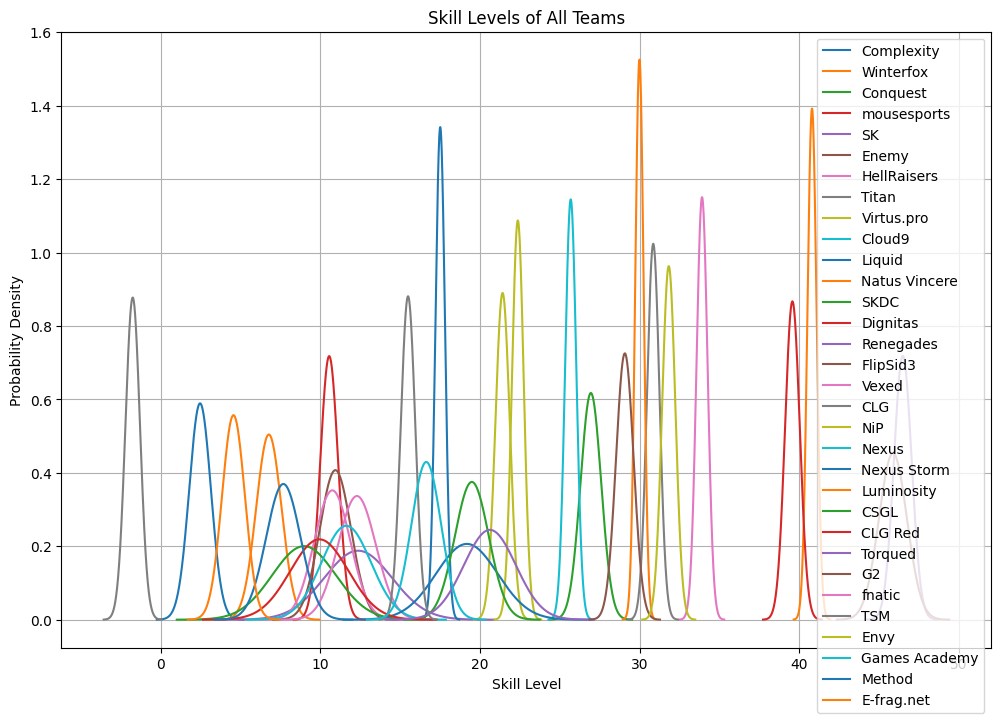

In [54]:
plt.figure(figsize=(12, 8))

for team in team_skills.keys():
    mean = team_skills[team]['mean']
    std_dev = np.sqrt(team_skills[team]['variance'])
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label=team)

plt.title('Skill Levels of All Teams')
plt.xlabel('Skill Level')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()